In [1]:
import os
import json
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from scipy.interpolate import splprep, splev
import lib.galaxy_utilities as gu
import lib.python_model_renderer.parse_annotation as pa
import lib.python_model_renderer.render_galaxy as rg
from model_scoring.model_fitting import Model, ModelFitter

In [2]:
catalog = fits.open(os.path.join('lib', 'NSA_GalaxyZoo.fits'))
hdu = catalog[1]
smooth = hdu.data['t01_smooth_or_features_a01_smooth_debiased'] > 0.5
featured = hdu.data['t01_smooth_or_features_a02_features_or_disk_debiased'] > 0.5
spiral = featured & (hdu.data['t04_spiral_a08_spiral_debiased'] > 0.5)
no_spiral = featured & (hdu.data['t04_spiral_a09_no_spiral_debiased'] > 0.5)

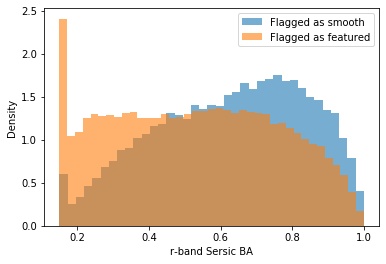

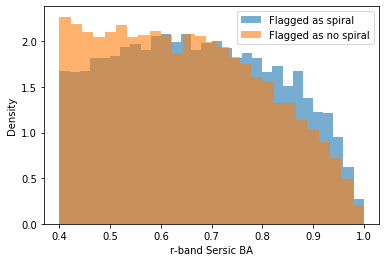

In [3]:
axRatios = hdu.data['SERSIC_BA']
plt.hist(axRatios[smooth], alpha=0.6, label='Flagged as smooth', bins='scott', density=True)
plt.hist(axRatios[featured], alpha=0.6, label='Flagged as featured', bins='scott', density=True)
plt.legend()
plt.xlabel('r-band Sersic BA')
plt.ylabel('Density');

plt.figure()
axRatios = hdu.data['SERSIC_BA']
plt.hist(axRatios[spiral & (axRatios > 0.4)], alpha=0.6, label='Flagged as spiral', bins='scott', density=True)
plt.hist(axRatios[no_spiral & (axRatios > 0.4)], alpha=0.6, label='Flagged as no spiral', bins='scott', density=True)
plt.legend()
plt.xlabel('r-band Sersic BA')
plt.ylabel('Density');

In [4]:
subject_id = 20902040

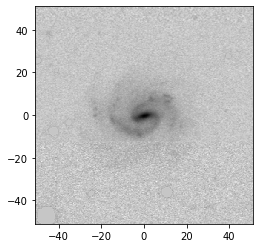

In [5]:
gal, angle = gu.get_galaxy_and_angle(subject_id)
pic_array, deprojected_image = gu.get_image(gal, subject_id, angle)
psf = gu.get_psf(subject_id)
diff_data = gu.get_image_data(subject_id)
pixel_mask = 1 - np.array(diff_data['mask'])[::-1]
galaxy_data = np.array(diff_data['imageData'])[::-1]
size_diff = diff_data['width'] / diff_data['imageWidth']
# arcseconds per pixel for zooniverse image
pix_size = pic_array.shape[0] / (gal['PETRO_THETA'].iloc[0] * 4)
# arcseconds per pixel for galaxy data
pix_size2 = galaxy_data.shape[0] / (gal['PETRO_THETA'].iloc[0] * 4)

imshow_kwargs = {
    'cmap': 'gray_r', 'origin': 'lower',
    'extent': (
        # left of image in arcseconds from centre
        -pic_array.shape[0]/2 / pix_size,
        pic_array.shape[0]/2 / pix_size,  # right...
        -pic_array.shape[1]/2 / pix_size,  # bottom...
        pic_array.shape[1]/2 / pix_size  # top...
    ),
}
plt.imshow(pic_array, **imshow_kwargs)

In [6]:
with open(
    'component-clustering/cluster-output/{}.json'.format(subject_id)
) as f:
    aggregate_model = json.load(f)

model = pa.parse_aggregate_model(aggregate_model, size_diff=size_diff)

CPU times: user 4.56 s, sys: 135 ms, total: 4.7 s
Wall time: 4.75 s


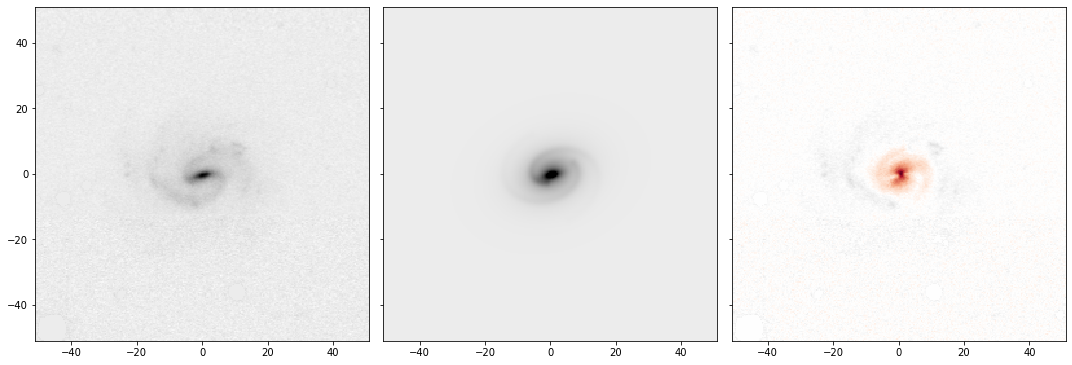

In [7]:
%time rendered = rg.calculate_model(model, diff_data['width'])
to_plot = rg.convolve2d(rendered, psf, mode='same', boundary='symm')
comparison = rg.compare_to_galaxy(rendered, psf, galaxy_data, pixel_mask=pixel_mask, stretch=False)
fig, ax = plt.subplots(ncols=3, sharey=True, figsize=(15, 6))
ax[0].imshow(0.8 * galaxy_data, **imshow_kwargs, vmin=(0.8 * galaxy_data).min(), vmax=(0.8 * galaxy_data).max())
ax[1].imshow(rendered, **imshow_kwargs, vmin=(0.8 * galaxy_data).min(), vmax=(0.8 * galaxy_data).max())
ax[2].imshow(comparison, **{**imshow_kwargs, 'cmap': 'RdGy'}, vmin=-np.abs(comparison).max(), vmax=np.abs(comparison).max())
plt.tight_layout();

In [8]:
mf = ModelFitter(model, galaxy_data, psf, pixel_mask)
md = mf.model
print('number of parameters to fit: {}'.format(len(mf.model.p)))

%time new_model, res = mf.fit(options={'maxiter': 10})

number of parameters to fit: 18


In [ ]:
%time new_rendered = rg.calculate_model(new_model, diff_data['width'])
to_plot = rg.convolve2d(new_rendered, psf, mode='same', boundary='symm')
comparison = rg.compare_to_galaxy(new_rendered, psf, galaxy_data, pixel_mask=pixel_mask, stretch=False)
fig, ax = plt.subplots(ncols=3, sharey=True, figsize=(15, 6))
ax[0].imshow(0.8 * galaxy_data, **imshow_kwargs, vmin=(0.8 * galaxy_data).min(), vmax=(0.8 * galaxy_data).max())
ax[1].imshow(new_rendered, **imshow_kwargs, vmin=(0.8 * galaxy_data).min(), vmax=(0.8 * galaxy_data).max())
ax[2].imshow(comparison, **{**imshow_kwargs, 'cmap': 'RdGy'}, vmin=-np.abs(comparison).max(), vmax=np.abs(comparison).max())
plt.tight_layout();

In [ ]:
with open('lib/best-classifications.json') as f:
  all_best_cls = json.load(f)
best_cls = gu.classifications[
    gu.classifications.classification_id == all_best_cls.get(str(subject_id))
].iloc[0]

In [ ]:
best_model = pa.parse_annotation(json.loads(best_cls['annotations']), size_diff)
best_mf = ModelFitter(best_model, galaxy_data, psf, pixel_mask)
print('number of parameters to fit: {}'.format(len(best_mf.model.p)))

%time best_model_optimized, res = best_mf.fit(options={'maxiter': 10})

In [ ]:
best_rendered = rg.calculate_model(best_model_optimized, diff_data['width'])
best_comparison = rg.compare_to_galaxy(best_rendered, psf, galaxy_data, pixel_mask=pixel_mask, stretch=False)

fig, ax = plt.subplots(nrows=2, ncols=2, sharey=True, figsize=(11, 11))
ax[0][0].imshow(best_rendered, **imshow_kwargs, vmin=(0.8 * galaxy_data).min(), vmax=(0.8 * galaxy_data).max())
ax[0][1].imshow(new_rendered, **imshow_kwargs, vmin=(0.8 * galaxy_data).min(), vmax=(0.8 * galaxy_data).max())
l = max(np.abs(best_comparison).max(), np.abs(comparison).max())
ax[1][0].imshow(
    best_comparison,
    **{**imshow_kwargs, 'cmap': 'RdGy'},
    vmin=-l, vmax=l
)
ax[1][1].imshow(
    comparison,
    **{**imshow_kwargs, 'cmap': 'RdGy'},
    vmin=-l, vmax=l
)
